In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

from tensorflow import keras
from PIL import Image

from keras.callbacks import EarlyStopping
import tensorflow as tf

In [10]:
data = pd.read_csv("river_data.csv")

data['SensorTime']= pd.to_datetime(data['SensorTime'])
data.head()

,SensorTime,CaptureTime,Filename,Agency,SiteNumber,TimeZone,Stage,Discharge,CalcTimestamp,width,...,WeirPt2X,WeirPt2Y,WwRawLineMin,WwRawLineMax,WwRawLineMean,WwRawLineSigma,WwCurveLineMin,WwCurveLineMax,WwCurveLineMean,WwCurveLineSigma
0,2012-06-09 13:15:00,2012-06-09T13:09:07,StateLineWeir_20120609_Farrell_001.jpg,USGS,6674500,MDT,2.99,916.0,2020-03-11T16:58:28,4288,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2012-06-09 13:15:00,2012-06-09T13:10:29,StateLineWeir_20120609_Farrell_002.jpg,USGS,6674500,MDT,2.99,916.0,2020-03-11T16:58:33,4288,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2012-06-09 13:45:00,2012-06-09T13:44:01,StateLineWeir_20120609_Farrell_003.jpg,USGS,6674500,MDT,2.96,873.0,2020-03-11T16:58:40,4288,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2012-06-09 14:45:00,2012-06-09T14:44:30,StateLineWeir_20120609_Farrell_004.jpg,USGS,6674500,MDT,2.94,846.0,2020-03-11T16:58:47,4288,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2012-06-09 15:45:00,2012-06-09T15:44:59,StateLineWeir_20120609_Farrell_005.jpg,USGS,6674500,MDT,2.94,846.0,2020-03-11T16:58:55,4288,...,-1,-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
train = pd.read_csv("./dates/train_data.csv")
test = pd.read_csv("./dates/test_data.csv")
validation = pd.read_csv("./dates/validation_data.csv")

Found 21421 validated image filenames.
Found 15242 validated image filenames.
Found 5396 validated image filenames.
2.25
512


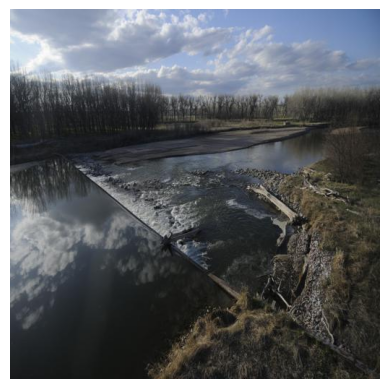

In [12]:
labels_train = train[[" Filename", " Stage"]]
labels_test = test[[" Filename", " Stage"]]
labels_validation = validation[[" Filename", " Stage"]]
generator = keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
)

train_generator=generator.flow_from_dataframe(
    dataframe=labels_train,
    directory="./dates/images/train",
    x_col=" Filename",
    y_col=" Stage",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(512,512))

test_generator = generator.flow_from_dataframe(
    dataframe=labels_test,
    directory="./dates/images/test",
    x_col=" Filename",
    y_col=" Stage",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(512,512))

validation_generator = generator.flow_from_dataframe(
    dataframe=labels_validation,
    directory="./dates/images/validation",
    x_col=" Filename",
    y_col=" Stage",
    batch_size=32,
    seed=42,
    shuffle=True,
    class_mode="raw",
    target_size=(512,512))

plt.imshow(validation_generator[0][0][0])
plt.axis('off')
print(validation_generator[0][1][0])
print(len(validation_generator[0][0][0]))

In [13]:
inputs = keras.Input(shape=(512, 512, 3))
x = keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(inputs)
x = keras.layers.MaxPool2D()(x)
x = keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = keras.layers.MaxPool2D()(x)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dense(64, activation='relu')(x)
outputs = keras.layers.Dense(1, activation='linear')(x)

In [14]:
model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    loss='mse', 
    optimizer='adam', 
    metrics=['mse', 'mae']
)
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    batch_size=32,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/10


2022-11-17 16:38:23.984504: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


670/670 [==============================] - ETA: 0s - loss: 0.9865 - mse: 0.9865 - mae: 0.6691

2022-11-17 16:40:21.309296: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


670/670 [==============================] - 135s 201ms/step - loss: 0.9865 - mse: 0.9865 - mae: 0.6691 - val_loss: 0.1913 - val_mse: 0.1913 - val_mae: 0.3690
Epoch 2/10
670/670 [==============================] - 134s 199ms/step - loss: 0.5882 - mse: 0.5882 - mae: 0.4823 - val_loss: 0.2274 - val_mse: 0.2274 - val_mae: 0.4007
Epoch 3/10
670/670 [==============================] - 132s 197ms/step - loss: 0.5059 - mse: 0.5059 - mae: 0.4380 - val_loss: 0.1593 - val_mse: 0.1593 - val_mae: 0.2952
Epoch 4/10
670/670 [==============================] - 131s 195ms/step - loss: 0.4404 - mse: 0.4404 - mae: 0.4076 - val_loss: 0.2495 - val_mse: 0.2495 - val_mae: 0.3509
Epoch 5/10
670/670 [==============================] - 131s 195ms/step - loss: 0.4186 - mse: 0.4186 - mae: 0.3972 - val_loss: 0.2279 - val_mse: 0.2279 - val_mae: 0.3184
Epoch 6/10
670/670 [==============================] - 132s 196ms/step - loss: 0.4138 - mse: 0.4138 - mae: 0.3952 - val_loss: 0.1420 - val_mse: 0.1420 - val_mae: 0.2452
Epo

In [15]:
rmse = np.sqrt(model.evaluate(test_generator, verbose=0))
print("Test RMSE: ",rmse)

Test RMSE:  [0.52862461 0.52862461 0.58414189]
